<a href="https://colab.research.google.com/github/KatyLefk/NN_Wine_Quality/blob/main/Wine_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Neural Network Pipeline

Απαραίτητες Βιβλιοθήκες για EDA, Plots και NNs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score

# Extra βιβλιοθήκες για το App
import joblib
import pickle
from google.colab import files

Συνάρτηση φόρτωσης των δεδομένων. Τα 2 csv χωρίζονται με διαφορετικό τρόπο οπότε δημιουργήθηκαν περιπτώσεις.

In [ ]:
def load_wine_data(wine_filepath):
    if wine_filepath=='winequality_red.csv':
      df_wn = pd.read_csv(wine_filepath)
    elif wine_filepath=='winequality_white.csv':
      df_wn = pd.read_csv(wine_filepath, sep=";")
    else:                                     # Σε περίπτωση λάθους
      print("Λάθος όνομα αρχείου")
    print(f"Το Dataset έχει μέγεθος: {df_wn.shape}")
    return df_wn

Συνάρτηση Εξερευνητικής Ανάλυσης Δεδομένων (Δείγμα, Στατιστικά, Κενές Τιμές, Τιμές ανά ποιότητα, Συσχέτιση)

In [ ]:
def wine_eda(df_wn):
    print("1. Δείγμα δεδομένων κρασιού:")
    display(df_wn.head())

    print("\n2. Στατιστικά περιγραφικά για όλες τις στήλες:") #\n για να βγαίνουν 1-1 σε ξεχωριστές γραμμές τα αποτελέσματα.
    display(df_wn.describe())

    print("\n3. Πληροφορίες για κενές τιμές και τύπους δεδομένων:")
    display(df_wn.info())

    print("\n4. Πλήθος τιμών ανά ποιότητα κρασιού:") # Διάγραμμα μόνο για την ποιότητα (αν χρειαστεί ξεχωριστά)
    sns.countplot(x='quality', data=df_wn)
    plt.title('Κατανομή Τιμών Ποιότητας Κρασιού')
    plt.show()

    print("\n5. Ιστόγραμμα για κάθε μεταβλητή:") # Περιλαμβάνει και την ποιότητα
    df_wn.hist(bins=15, figsize=(15, 10), color='purple')
    plt.tight_layout()
    plt.show()

    print("\n6. Heatmap συσχετίσεων για όλες τις μεταβλητές:")
    plt.figure(figsize=(12, 8))
    wn_corr = df_wn.corr()
    sns.heatmap(wn_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Συντελεστές Συσχέτισης μεταξύ Μεταβλητών")
    plt.show()

    print("\n7. Συσχέτιση όλων των μεταβλητών με την ποιότητα:")
    corr_quality = wn_corr['quality'].sort_values(ascending=False)
    print(corr_quality)


Συνάρτηση που εκτυπώνει για κάθε PCA component τα top_n χαρακτηριστικά που συμβάλλουν περισσότερο. Χρήση: μόνο για την κατανόηση.

In [ ]:
def show_pca_contributions(pca, feature_names, top_n=3):

    for i, component in enumerate(pca.components_):
        print(f"\nComponent {i+1}:")
        # Ταξινόμηση συντελεστών κατά απόλυτη τιμή (το μεγαλύτερο πρώτα)
        sorted_idx = np.argsort(np.abs(component))[::-1]
        for idx in sorted_idx[:top_n]:
            print(f"  {feature_names[idx]}: {component[idx]:.3f}")


Συνάρτηση προεπεξεργασίας δεδομένων (στόχος η Ποιότητα, δυνατότητα τυποποίησης για καλύτερη σύγκλιση του μοντέλου και χωρισμός των δεδομένων σε train & test (80-20) πριν από την εκπαίδευση.


In [ ]:
def preprocess_data_for_nn(df_wn, wn_scaler_type='standard', pca_apply=False, pca_variance=0.95, one_hot=False):
    print("\n8. Σύγκριση πριν και μετά την τυποποίηση των δεδομένων:")
    X = df_wn.drop('quality', axis=1) # βγάζουμε το στόχο
    y = df_wn['quality']  # multiclass classification

    # minimum quality score για zero-indexed ετικέτες - απαραίτητο
    min_w_quality = y.min()
    y = y - min_w_quality

    # scaler
    if wn_scaler_type=='standard':
        wn_values_scaler = StandardScaler()
        X_wn_scaled = wn_values_scaler.fit_transform(X)
        plot_stdrd_comparison(X, X_wn_scaled)   # boxplots
    elif wn_scaler_type=='minmax':
        wn_values_scaler = MinMaxScaler()
        X_wn_scaled = wn_values_scaler.fit_transform(X)
        plot_stdrd_comparison(X, X_wn_scaled)  # boxplots
    elif wn_scaler_type is None:
        X_wn_scaled = X.values  # Χωρίς scaling #change_scaler_to_None
        print("Δεν εφαρμόστηκε scaler.")
    else:
        raise ValueError("Ο scaler type (2η μεταβλητή) πρέπει να είναι 'standard', 'minmax' ή None")


    X_train, X_test, y_train, y_test = train_test_split(
        X_wn_scaled, y, test_size=0.2, random_state=42, stratify=y # Τα χωρίσει 80-20
    )

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    # One-hot για categorical_crossentropy
    if one_hot:
        num_classes = y_train.nunique()
        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

    # PCA
    if pca_apply:
        pca = PCA(n_components=pca_variance)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA: Από {X.shape[1]} → {X_train.shape[1]} χαρακτηριστικά")
        show_pca_contributions(pca, wine_df.drop('quality', axis=1).columns, top_n=3)

    else:
        pca = None


    return X_train, X_test, y_train, y_test, pca, wn_values_scaler

Plot StandardScaler για να δείξουμε ότι έχουν μ.τ. 0 και διασπορά 1 ή MinMax όπου τα δεδομένα ανήκουν σε συγκεκριμένο σύνολο τιμών. Χρησιμοποιείται όταν τρέξει η προηγούμενη συνάρτηση.

In [ ]:
def plot_stdrd_comparison(df_original, df_scaled): #Συγκρίνει πριν και μετά την τυποποίηση με boxplot original vs scaled
    df_scaled = pd.DataFrame(df_scaled, columns=df_original.columns)
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    df_original.boxplot(rot=90)
    plt.title("Πριν την κλιμάκωση")
    plt.subplot(1,2,2)
    df_scaled.boxplot(rot=90)
    plt.title("Μετά την κλιμάκωση")
    plt.tight_layout()
    plt.show()

Δημιουργία Νευρωνικού Δικτύου. Στα πειράματα αλλάζει ότι έχει σχόλιο με _change δίπλα (αριθμός levels  νευρώνες, optimizer, learning rate).

In [ ]:
def build_model(input_shape, num_classes, use_dropout=False, optimizer='adam', loss_fn='sparse_categorical_crossentropy'):
    nn_wine_model = Sequential()
    # nn_wine_model.add(Dense(256, activation='relu', input_shape=(input_shape,))) # input layer
    # if use_dropout:
    #     nn_wine_model.add(Dropout(0.3))
    # nn_wine_model.add(Dense(128, activation='relu')) # change_add layer
    # if use_dropout:
    #    nn_wine_model.add(Dropout(0.3))
    nn_wine_model.add(Dense(256, activation='relu')) # change_add layer
    if use_dropout:
        nn_wine_model.add(Dropout(0.3))
    nn_wine_model.add(Dense(128, activation='relu')) # change_add layer
    if use_dropout:
        nn_wine_model.add(Dropout(0.3))
    nn_wine_model.add(Dense(64, activation='relu')) # change_add layer
    if use_dropout:
        nn_wine_model.add(Dropout(0.3))
    nn_wine_model.add(Dense(num_classes, activation='softmax')) # output layer

    # Επιλογή optimizer
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) #change_lr_sgd
    # elif optimizer == 'adam':
    #     opt = tf.keras.optimizers.Adam(learning_rate=0.0005)  #change_lr_adam
    else:
        opt = optimizer #if Adam : default learning rate = 0.001

    nn_wine_model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return nn_wine_model

Εκπαίδευση του ΝΝ (Στα πειράματα αλλαγές στις υπερπαραμέτρους epocs και batch size)

In [ ]:
def train_nn(model, X_train, y_train, epochs=100, batch_size=32): #change_batch #change_epochs
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    #history = model.fit(X_train_sub, y_train_sub, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=0)
    return history

Συνάρτηση Αξιολόγησης του ΝΝ με τις μεταβλητές που του δώσαμε

In [ ]:
def evaluate_nn(model, X_test, y_test, one_hot=False):
    nn_y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(nn_y_pred_probs, axis=1) if one_hot else np.argmax(nn_y_pred_probs, axis=1) # Περίπτωση one hot για την categorical crossentropy
    y_true = np.argmax(y_test, axis=1) if one_hot else y_test
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

Συνάρτηση εκτύπωσης των μετρικών σε μια γραμμή ώστε να είναι εύκολο ναμπουν στο τελικό Excel πειραμάτων.

In [ ]:
def print_metrics_excel(model, history, X_train, y_train, X_test, y_test, one_hot=False):

    # Train & Val από history
    train_acc = history.history['accuracy'][-1]
    val_acc   = history.history['val_accuracy'][-1]

    # Predictions εσωτερική συνάρτηση
    def process_preds(X, y):
        y_pred_wine_probs = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred_wine_probs, axis=1) if one_hot else np.argmax(y_pred_wine_probs, axis=1)
        y_true = np.argmax(y, axis=1) if one_hot else y
        return y_true, y_pred

    y_train_true, y_train_pred = process_preds(X_train, y_train)
    y_test_true, y_test_pred   = process_preds(X_test, y_test)

    # Accuracy
    test_acc = np.mean(y_test_pred == y_test_true)

    # Precision, Recall, F1
    train_precision = precision_score(y_train_true, y_train_pred, average='macro')
    test_precision  = precision_score(y_test_true, y_test_pred, average='macro')

    train_recall = recall_score(y_train_true, y_train_pred, average='macro')
    test_recall  = recall_score(y_test_true, y_test_pred, average='macro')

    train_f1 = f1_score(y_train_true, y_train_pred, average='macro')
    test_f1  = f1_score(y_test_true, y_test_pred, average='macro')


    # Val metrics από history
    val_precision = history.history.get('val_precision', [np.nan])[-1]
    val_recall    = history.history.get('val_recall', [np.nan])[-1]
    val_f1        = history.history.get('val_f1', [np.nan])[-1]

    # Εκτύπωση σε μία γραμμή για το Excel
    print(f"{train_acc:.4f}\t{val_acc:.4f}\t{test_acc:.4f}\t"
          f"{train_precision:.4f}\t{val_precision:.4f}\t{test_precision:.4f}\t"
          f"{train_recall:.4f}\t{val_recall:.4f}\t{test_recall:.4f}\t"
          f"{train_f1:.4f}\t{val_f1:.4f}\t{test_f1:.4f}")


Συνάρτηση που δημιουργεί 2 διαγράμματα με το σφάλμα (loss) και την ακρίβεια (accuracy) ανά epoch.

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Loss') # loss = η απώλεια στο training set (τα δεδομένα που το μοντέλο μαθαίνει).
    plt.plot(history.history['val_loss'], label='Val Loss') # val_loss = η απώλεια στο validation set, δηλαδή σε δεδομένα που δεν είδε το μοντέλο κατά την εκπαίδευση.
    plt.title('Loss ανά Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy ανά Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

MAIN Εκτέλεση pipeline (όλες οι παραπάνω συναρήσεις με τη σειρά που πρέπει να τρέξουν)

Το Dataset έχει μέγεθος: (1599, 12)
1. Δείγμα δεδομένων κρασιού:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



2. Στατιστικά περιγραφικά για όλες τις στήλες:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



3. Πληροφορίες για κενές τιμές και τύπους δεδομένων:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None


4. Πλήθος τιμών ανά ποιότητα κρασιού:


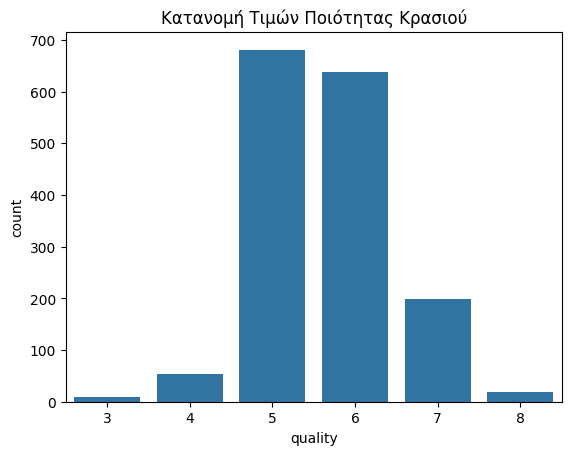


5. Ιστόγραμμα για κάθε μεταβλητή:


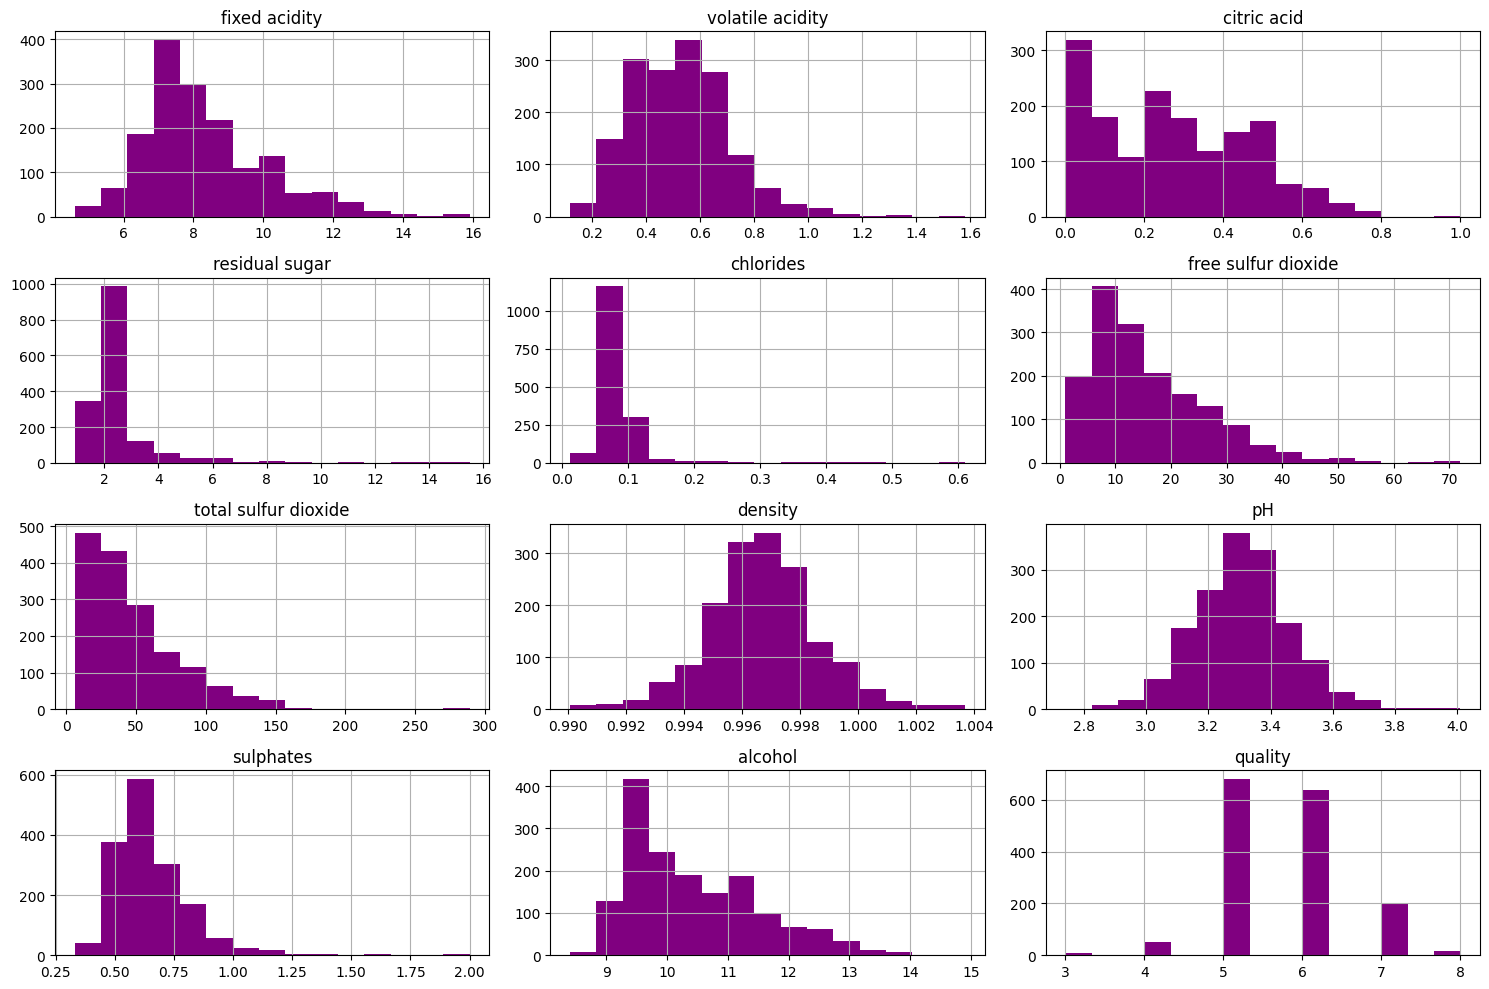


6. Heatmap συσχετίσεων για όλες τις μεταβλητές:


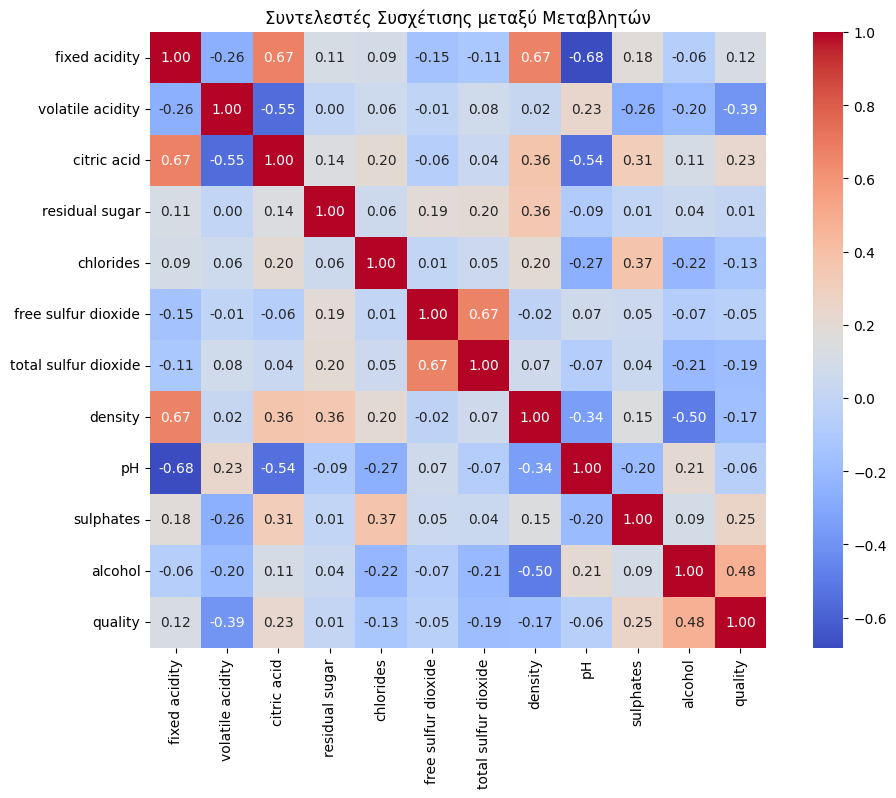


7. Συσχέτιση όλων των μεταβλητών με την ποιότητα:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

8. Σύγκριση πριν και μετά την τυποποίηση των δεδομένων:


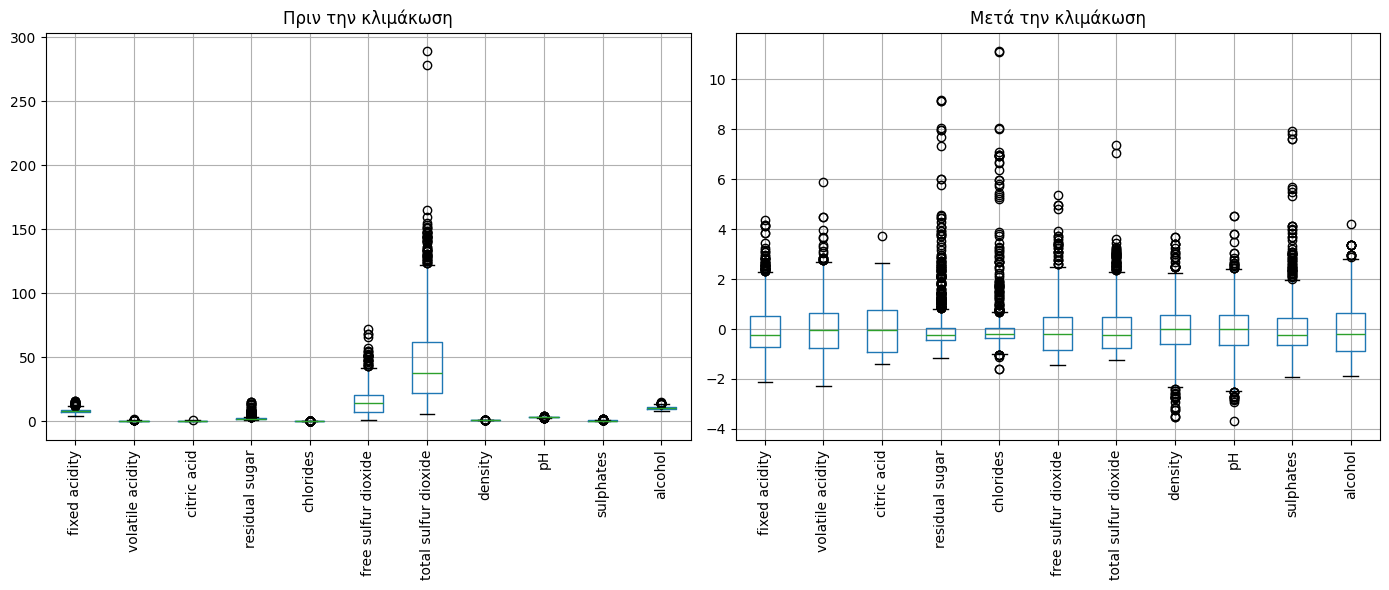

PCA: Από 11 → 9 χαρακτηριστικά

Component 1:
  citric acid: 0.458
  fixed acidity: 0.451
  pH: -0.430

Component 2:
  total sulfur dioxide: 0.576
  free sulfur dioxide: 0.517
  alcohol: -0.391

Component 3:
  alcohol: 0.480
  volatile acidity: -0.432
  free sulfur dioxide: 0.423

Component 4:
  chlorides: 0.682
  sulphates: 0.540
  residual sugar: -0.285

Component 5:
  residual sugar: 0.782
  alcohol: 0.360
  volatile acidity: 0.252

Component 6:
  sulphates: 0.552
  pH: 0.452
  density: 0.415

Component 7:
  volatile acidity: 0.631
  alcohol: 0.387
  sulphates: 0.353

Component 8:
  pH: 0.538
  free sulfur dioxide: 0.367
  residual sugar: -0.330

Component 9:
  free sulfur dioxide: 0.573
  total sulfur dioxide: -0.561
  citric acid: -0.445
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[ 0  0  1  1  0  0]
 [ 0  1  8  2  0  0]
 [ 0  3 98 34  1  0]
 [ 0  0 34 79 15  0]
 [ 0  0  1 17 21  1]
 [ 0  0  1  1  1  0]]
              precision    recall  f1-score   support

           0       0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


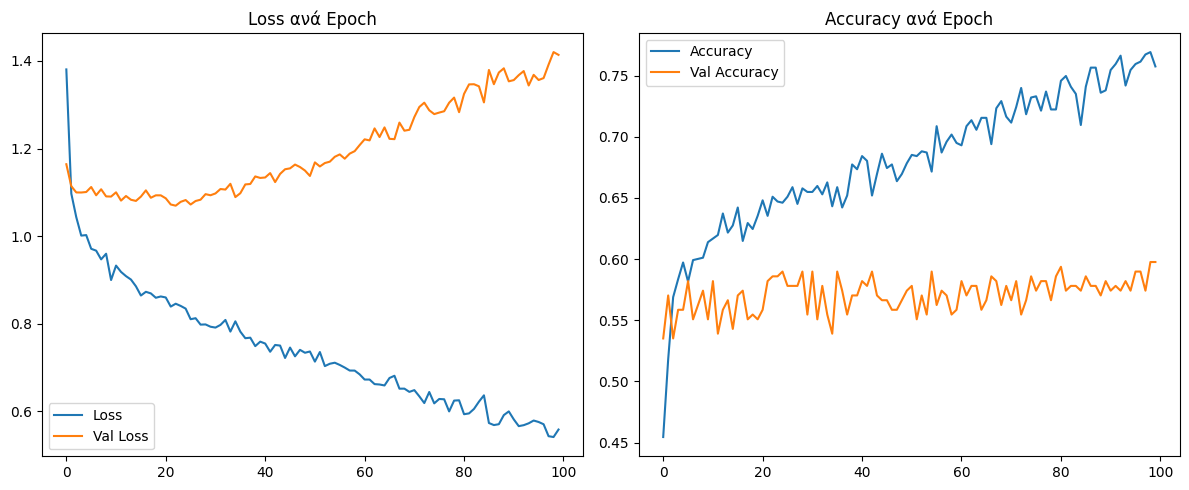

Train Acc	Val Acc	Test Acc	Train Precision	Val Precision	Test Precision	Train Recall	Val Recall	Test Recall	Train F1	Val F1	Test F1
0.7576	0.5977	0.6219	0.8685	nan	0.3462	0.5997	nan	0.3256	0.6787	nan	0.3296


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
wine_csv_path = 'winequality_red.csv' # change_file
wine_df = load_wine_data(wine_csv_path)
wine_eda(wine_df)

X_train, X_test, y_train, y_test, pca, scaler = preprocess_data_for_nn(
    wine_df, scaler_type='standard', pca_apply=True, pca_variance=0.95, one_hot=True #False για sparse (αν προστεθεί τελικά) #change_pca #change_scaler "standard" ή "minmax"
)

model = build_model(
    input_shape=X_train.shape[1],
    num_classes=y_train.shape[1],
    use_dropout=True, #change_dropout
    optimizer='adam', #change_optimizer "sgd" ή "adam"
    loss_fn='categorical_crossentropy' #change_function
)

# Εκπαίδευση του μοντέλου
history = train_nn(model, X_train, y_train)

# Αξιολόγηση του μοντέλου
evaluate_nn(model, X_test, y_test, one_hot=True) #one_hot = false για sparse

# Οπτικοποίηση metrics of wine model
plot_metrics(history)

# Excel
print("Train Acc\tVal Acc\tTest Acc\tTrain Precision\tVal Precision\tTest Precision\tTrain Recall\tVal Recall\tTest Recall\tTrain F1\tVal F1\tTest F1")
print_metrics_excel(model, history, X_train, y_train, X_test, y_test, one_hot=True)


Επιλέγεται ο κύκλος και διαβάζονται τα Test Accuracies από το excel των αποτελεσμάτων. (Προεραιτικό)

/tmp/ipython-input-1491753406.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Experiment ID', y='Test Acc', data=df_subset, palette=colors)
/tmp/ipython-input-1491753406.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='Experiment ID', y='Test Acc', data=df_subset, palette=colors)


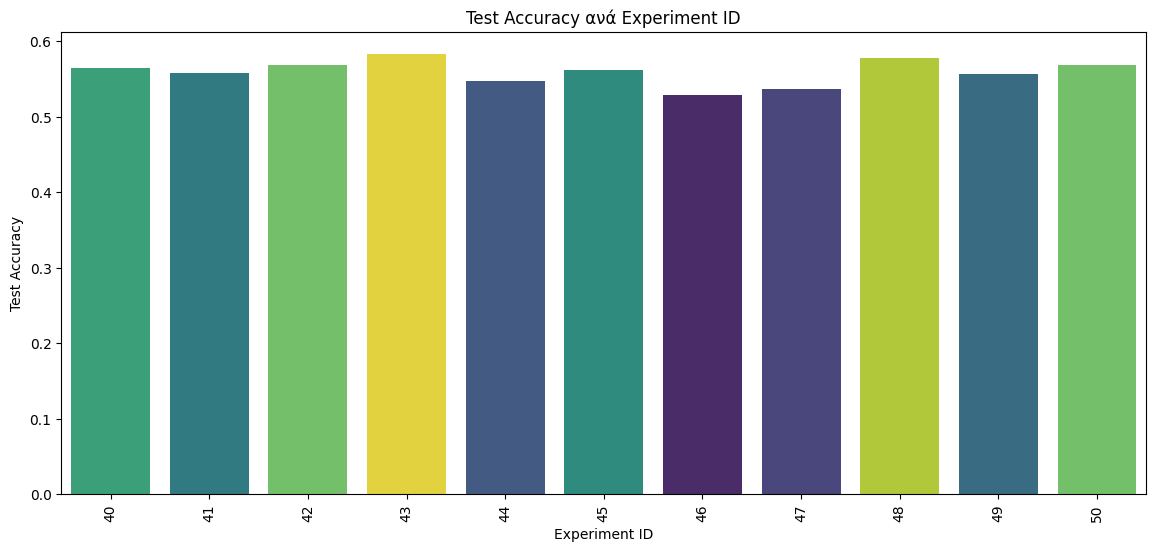

In [ ]:
# Φόρτωση Excel
df = pd.read_excel("experiments_plan.xlsx", sheet_name="White_exps")

# df_subset = df.iloc[:40]  # Πειράματα Α κύκλου
df_subset = df.iloc[39:50]  # Πειράματα Β κύκλου
# df_subset = df.iloc[50:]  # Πειράματα Γ κύκλου

colors = sns.color_palette("viridis", as_cmap=True)(df_subset['Test Acc'].rank(pct=True)) # Υψηλότερη ακρίβεια δίνει και πιο ανοιχτόχρωμο bar

# Βασική εικόνα: Test Accuracy ανά Experiment ID
plt.figure(figsize=(14,6))
sns.barplot(x='Experiment ID', y='Test Acc', data=df_subset, palette=colors)
plt.xticks(rotation=90)
plt.title("Test Accuracy ανά Experiment ID")
plt.ylabel("Test Accuracy")
plt.xlabel("Experiment ID")
plt.show()


Κώδικας Αποθήκευσης μεταβλητών για τη δημιουργία εφαρμογής. Η πιο σημαντική είναι το μοντέλo. To PCA μπορεί και να μην χρησιμοποιηθεί καθόλου, αναλόγως το πείραμα.

In [ ]:
# Αποθήκευση PCA
if pca is not None:
    joblib.dump(pca, 'pca.pkl')
    print("Αποθηκεύτηκε 'pca.pkl'")

# Αποθήκευση Scaler
joblib.dump(scaler, 'scaler.pkl')
print("Αποθηκεύτηκε 'scaler.pkl'")

# Αποθήκευση μοντέλου
model.save('wine_nn_model.h5')
print("Αποθηκεύτηκε 'wine_nn_model.h5'")


PCA αποθηκεύτηκε ως 'pca.pkl'
Scaler αποθηκεύτηκε ως 'scaler.pkl'
Μοντέλο NN αποθηκεύτηκε ως 'wine_nn_model.h5'


Κατέβασμα αρχείων ώστε να μαζευτούν στο φάκελο με την εφαρμογή και να τρέξουν όλα μαζί.

In [ ]:
# Κατέβασμα αρχείων
files.download('pca.pkl')
files.download('scaler.pkl')
files.download('wine_nn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>